In [1]:
import duckdb
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from pyproj import Geod
from shapely import geometry, box
import statsmodels.api as sm

### Settings

In [2]:
# which projection to use
# https://en.wikipedia.org/wiki/World_Geodetic_System
geod=Geod(ellps='WGS84')  

### Functions

In [3]:
def get_lat_long_windows(start_lat, start_long, n_boxes=12):
    """ 
    Generate & return a series of boxes of increasing size,
    approximately centered at the given latitude and longitude. 
    np.logspace generates a range of numbers that are evenly spaced in
    the given base -- useful here as we think we're working with a power law
    distribution.
    """
    boxes = []
    for x in np.logspace(-1, 5, num=n_boxes, base=10):
        boxes.append(
            {"min_lat": start_lat * x // 1 / x,
             "max_lat": (start_lat * x // 1 + 1) / x,
             "min_long": start_long * x // 1 / x,
             "max_long": (start_long * x // 1 + 1) / x
            })
    return boxes

def area_km(b):
    """ return the area on earth of the given lat/long-defined polygon.
    The projection is defined above in settings.
    geod.geometry_area_perimeter returns a tuple of (area, perimeter)
    where area is in m^2. We convert to km^2.
    """
    return geod.geometry_area_perimeter(b)[0]/(1000*1000)

def multiwindow_species_count_select(windows):
    """
    For a set of windows as generated with with `get_lat_long_windows`,
    format a big select statement that selects the count of species
    within each area. 
    Doesn't run the statement, just generates the SQL needed for it.
    """
    selects = []
    for w in windows:
        selects.append(f"""
            (SELECT
                {w["min_lat"]} AS min_lat,
                {w["max_lat"]} AS max_lat,
                {w["min_long"]} AS min_long,
                {w["max_long"]} AS max_long,
                count(distinct scientific_name) as species_count,
            FROM read_parquet(['data/ebird_2022.parquet', 'data/ebird_2021.parquet', 'data/ebird_2020.parquet'])
            WHERE latitude >= {w["min_lat"]}
            AND latitude < {w["max_lat"]}
            AND longitude >= {w["min_long"]}
            AND longitude < {w["max_long"]}
            GROUP BY 1,2,3,4)
        """)

    return "\n UNION \n".join(selects)

def df_with_area(df):
    """
    Add area calculations to the dataframe.
    """
    df['shapely_box'] = box(df['max_long'], df['max_lat'], df['min_long'], df['min_lat'])
    df['area_km'] = df['shapely_box'].map(area_km)
    return df

def df_with_log10(df):
    """
    Add log10 columns to the dataframe.
    """
    df['log10_area_km'] = np.log10(df['area_km'])
    df['log10_species_count'] = np.log10(df['species_count'])
    return df

def best_fit_line(df):
    scaling_regime_min = 0.5
    scaling_regime_max = 7
    df = df.sort_values(by='log10_area_km')
    scaling_range = df[(df['log10_area_km'] < scaling_regime_max) & (df['log10_area_km'] >= scaling_regime_min)]
    x = scaling_range['log10_area_km']
    X = sm.add_constant(x)
    line = sm.OLS(scaling_range['log10_species_count'], X).fit()
    slope = line.params.log10_area_km
    intercept = line.params.const
    print(line.summary2())
    y = scaling_range['log10_area_km'] * slope + intercept
    return x,y,slope


## Land Only

### Burlington, VT-centered

In [4]:
# Run query and convert to dataframe
input_lat = 44.461917
input_long = -73.212406
windows = get_lat_long_windows(input_lat, input_long)
big_select = multiwindow_species_count_select(windows)
vt_df = duckdb.sql(big_select).df()
vt_df.sort_values(by="min_lat")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,min_lat,max_lat,min_long,max_long,species_count
1,40.000000,50.000000,-80.000000,-70.000000,831
6,42.720538,45.568574,-74.048933,-71.200897,504
2,43.801065,44.612196,-73.812906,-73.001775,400
4,44.354490,44.585503,-73.231111,-73.000099,311
3,44.410493,44.476286,-73.227968,-73.162175,254
5,44.446949,44.465687,-73.228785,-73.210047,179
0,44.460041,44.465378,-73.214177,-73.208840,83


In [5]:
# Add necessary columns
vt_df = df_with_area(vt_df)
vt_df = df_with_log10(vt_df)

In [6]:
vt_x, vt_y, slope = best_fit_line(vt_df)

                   Results: Ordinary least squares
Model:              OLS                 Adj. R-squared:     0.951    
Dependent Variable: log10_species_count AIC:                -15.6125 
Date:               2023-12-13 11:11    BIC:                -16.3937 
No. Observations:   5                   Log-Likelihood:     9.8063   
Df Model:           1                   F-statistic:        79.47    
Df Residuals:       3                   Prob (F-statistic): 0.00298  
R-squared:          0.964               Scale:              0.0019313
-----------------------------------------------------------------------
                 Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
-----------------------------------------------------------------------
const            2.1965     0.0519   42.3532   0.0000   2.0315   2.3615
log10_area_km    0.1136     0.0127    8.9145   0.0030   0.0731   0.1542
---------------------------------------------------------------------
Omnibus:                nan  

/Users/annepope/.venv/ebirdy/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Text(0.5, 0.98, 'Starting in Burlington, VT')

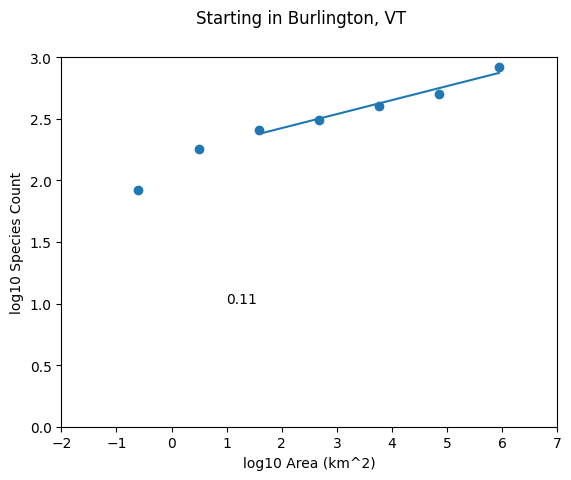

In [7]:
# Plot
fig, ax = plt.subplots()
ax.scatter(vt_df['log10_area_km'], vt_df['log10_species_count'])
ax.set_xlabel("log10 Area (km^2)")
ax.set_ylabel("log10 Species Count")
ax.set_ylim(0, 3)
ax.set_xlim(-2, 7)
ax.plot(vt_x, vt_y)
ax.text(1, 1, f"{slope:.2f}")
fig.suptitle("Starting in Burlington, VT")

### El Paso, Texas - centered

In [8]:
# Run query and convert to dataframe

input_lat = 31.78886
input_long = -106.4572
windows = get_lat_long_windows(input_lat, input_long)
big_select = multiwindow_species_count_select(windows)
tx_df = duckdb.sql(big_select).df()
tx_df.sort_values(by="min_lat")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,min_lat,max_lat,min_long,max_long,species_count
2,30.000000,40.000000,-110.000000,-100.000000,885
5,31.328395,34.176430,-108.225363,-105.377327,568
1,31.634102,32.445233,-107.069270,-106.258139,483
4,31.648777,31.879790,-106.496979,-106.265966,350
3,31.778175,31.843968,-106.519389,-106.453596,232
0,31.779943,31.798682,-106.470306,-106.451568,186
6,31.785381,31.790717,-106.461813,-106.456476,185
7,31.787420,31.788940,-106.457612,-106.456092,14


In [9]:
# Add necessary columns
tx_df = df_with_area(tx_df)
tx_df = df_with_log10(tx_df)

In [10]:
tx_x, tx_y, slope = best_fit_line(tx_df)

                   Results: Ordinary least squares
Model:              OLS                 Adj. R-squared:     0.986     
Dependent Variable: log10_species_count AIC:                -23.3343  
Date:               2023-12-13 11:12    BIC:                -23.7508  
No. Observations:   6                   Log-Likelihood:     13.667    
Df Model:           1                   F-statistic:        341.0     
Df Residuals:       4                   Prob (F-statistic): 5.06e-05  
R-squared:          0.988               Scale:              0.00092277
------------------------------------------------------------------------
                  Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
------------------------------------------------------------------------
const             2.1886     0.0252   86.7898   0.0000   2.1186   2.2586
log10_area_km     0.1232     0.0067   18.4667   0.0001   0.1047   0.1418
----------------------------------------------------------------------
Omnibus:        

/Users/annepope/.venv/ebirdy/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Text(0.5, 0.98, 'Starting in El Paso, Texas')

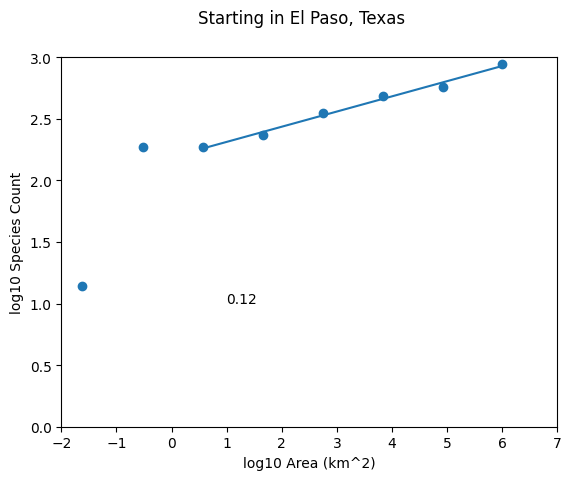

In [11]:
# Plot
fig, ax = plt.subplots()
ax.scatter(tx_df['log10_area_km'], tx_df['log10_species_count'])
ax.set_xlabel("log10 Area (km^2)")
ax.set_ylabel("log10 Species Count")
ax.set_ylim(0, 3)
ax.set_xlim(-2, 7)
ax.plot(tx_x, tx_y)
ax.text(1, 1, f"{slope:.2f}")
fig.suptitle("Starting in El Paso, Texas")

### Starting in Boise, Idaho

In [12]:
# Run query and convert to dataframe

input_lat = 43.60948
input_long = -116.2176
windows = get_lat_long_windows(input_lat, input_long)
big_select = multiwindow_species_count_select(windows)
id_df = duckdb.sql(big_select).df()
id_df.sort_values(by="min_lat")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,min_lat,max_lat,min_long,max_long,species_count
5,40.000000,50.000000,-120.000000,-110.000000,702
4,42.720538,45.568574,-116.769471,-113.921435,442
6,42.989934,43.801065,-116.802840,-115.991709,408
3,43.430438,43.661451,-116.430537,-116.199524,286
0,43.555179,43.620973,-116.256801,-116.191007,213
2,43.603731,43.622470,-116.232895,-116.214157,186
1,43.606169,43.611506,-116.222636,-116.217299,87


In [13]:
# Add necessary columns
id_df = df_with_area(id_df)
id_df = df_with_log10(id_df)

In [14]:
id_x, id_y, slope = best_fit_line(id_df)

                   Results: Ordinary least squares
Model:              OLS                 Adj. R-squared:     0.960    
Dependent Variable: log10_species_count AIC:                -16.6942 
Date:               2023-12-13 11:27    BIC:                -17.4753 
No. Observations:   5                   Log-Likelihood:     10.347   
Df Model:           1                   F-statistic:        96.46    
Df Residuals:       3                   Prob (F-statistic): 0.00224  
R-squared:          0.970               Scale:              0.0015556
-----------------------------------------------------------------------
                 Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
-----------------------------------------------------------------------
const            2.1532     0.0467   46.1531   0.0000   2.0048   2.3017
log10_area_km    0.1126     0.0115    9.8214   0.0022   0.0761   0.1490
---------------------------------------------------------------------
Omnibus:               nan   

/Users/annepope/.venv/ebirdy/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Text(0.5, 0.98, 'Starting in Boise, Idaho')

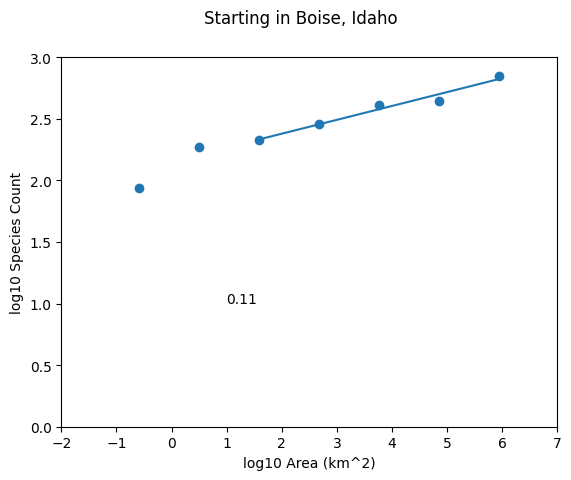

In [15]:
# Plot
fig, ax = plt.subplots()
ax.scatter(id_df['log10_area_km'], id_df['log10_species_count'])
ax.set_xlabel("log10 Area (km^2)")
ax.set_ylabel("log10 Species Count")
ax.set_ylim(0, 3)
ax.set_xlim(-2, 7)
ax.plot(id_x, id_y)
ax.text(1, 1, f"{slope:.2f}")
fig.suptitle("Starting in Boise, Idaho")

### Starting in St. Louis, Missouri

In [16]:
 # Run query and convert to dataframe

input_lat = 38.60988
input_long = -90.26047
windows = get_lat_long_windows(input_lat, input_long)
big_select = multiwindow_species_count_select(windows)
mo_df = duckdb.sql(big_select).df()
mo_df.sort_values(by="min_lat")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,min_lat,max_lat,min_long,max_long,species_count
2,30.000000,40.000000,-100.000000,-90.000000,796
3,37.024466,39.872502,-91.137148,-88.289112,479
6,38.123149,38.934280,-90.846653,-90.035522,440
1,38.554887,38.620680,-90.268438,-90.202645,243
4,38.579166,38.810179,-90.326071,-90.095058,308
5,38.600639,38.619377,-90.261785,-90.243047,211
7,38.605682,38.611019,-90.264931,-90.259594,108
0,38.608781,38.610301,-90.261440,-90.259920,72


In [17]:
# Add necessary columns
mo_df = df_with_area(mo_df)
mo_df = df_with_log10(mo_df)

In [18]:
mo_x, mo_y, slope = best_fit_line(mo_df)

                   Results: Ordinary least squares
Model:              OLS                 Adj. R-squared:     0.956    
Dependent Variable: log10_species_count AIC:                -18.6047 
Date:               2023-12-13 11:28    BIC:                -19.0212 
No. Observations:   6                   Log-Likelihood:     11.302   
Df Model:           1                   F-statistic:        108.4    
Df Residuals:       4                   Prob (F-statistic): 0.000481 
R-squared:          0.964               Scale:              0.0020297
-----------------------------------------------------------------------
                 Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
-----------------------------------------------------------------------
const            2.2362     0.0370   60.4270   0.0000   2.1335   2.3390
log10_area_km    0.1025     0.0098   10.4102   0.0005   0.0752   0.1298
---------------------------------------------------------------------
Omnibus:               nan   

/Users/annepope/.venv/ebirdy/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Text(0.5, 0.98, 'Starting in St. Louis, Missouri')

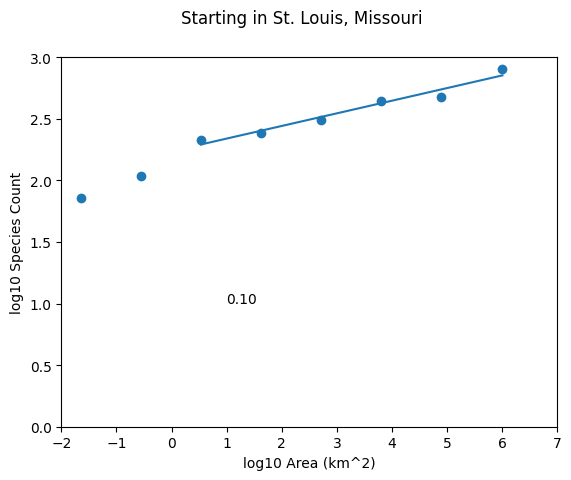

In [19]:
# Plot
fig, ax = plt.subplots()
ax.scatter(mo_df['log10_area_km'], mo_df['log10_species_count'])
ax.set_xlabel("log10 Area (km^2)")
ax.set_ylabel("log10 Species Count")
ax.set_ylim(0, 3)
ax.set_xlim(-2, 7)
ax.plot(mo_x, mo_y)
ax.text(1, 1, f"{slope:.2f}")
fig.suptitle("Starting in St. Louis, Missouri")

### All areas grouped

In [42]:
new_df = pd.concat([id_df, tx_df, vt_df, mo_df])
total_x, total_y, slope = best_fit_line(new_df)

                   Results: Ordinary least squares
Model:              OLS                 Adj. R-squared:     0.951    
Dependent Variable: log10_species_count AIC:                -71.9322 
Date:               2023-12-13 14:51    BIC:                -69.7501 
No. Observations:   22                  Log-Likelihood:     37.966   
Df Model:           1                   F-statistic:        405.9    
Df Residuals:       20                  Prob (F-statistic): 9.39e-15 
R-squared:          0.953               Scale:              0.0020416
-----------------------------------------------------------------------
                Coef.    Std.Err.      t       P>|t|    [0.025   0.975]
-----------------------------------------------------------------------
const           2.2007     0.0216   101.7813   0.0000   2.1556   2.2458
log10_area_km   0.1115     0.0055    20.1468   0.0000   0.0999   0.1230
---------------------------------------------------------------------
Omnibus:               0.161 

Text(0.5, 0.98, 'Contiguous Land: Bird Species Counts vs. Area')

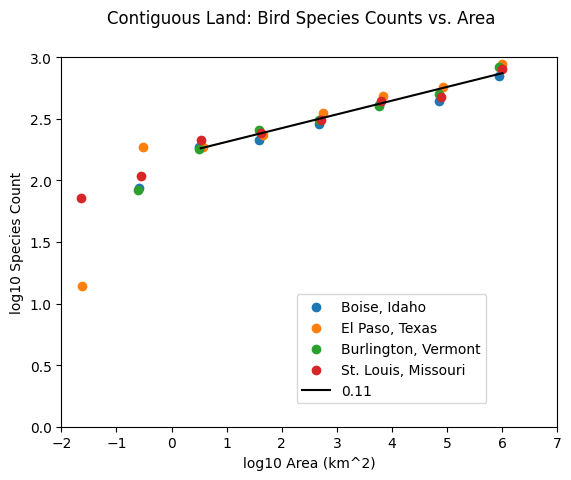

In [45]:
# Plot
fig, ax = plt.subplots()
ax.scatter(id_df['log10_area_km'], id_df['log10_species_count'], label="Boise, Idaho")
ax.scatter(tx_df['log10_area_km'], tx_df['log10_species_count'], label="El Paso, Texas")
ax.scatter(vt_df['log10_area_km'], vt_df['log10_species_count'], label="Burlington, Vermont")
ax.scatter(mo_df['log10_area_km'], mo_df['log10_species_count'], label="St. Louis, Missouri")
ax.set_xlabel("log10 Area (km^2)")
ax.set_ylabel("log10 Species Count")
ax.set_ylim(0, 3)
ax.set_xlim(-2, 7)
ax.plot(total_x, total_y, color='black', label=f"{slope:.2f}")
# ax.text(1, 1, f"{slope:.2f}")
# fig.legend(loc='center right')
fig.legend(bbox_to_anchor=(0.8, 0.4))
fig.suptitle("Contiguous Land: Bird Species Counts vs. Area")

Text(0.5, 0.98, 'Species Counts vs. Area')

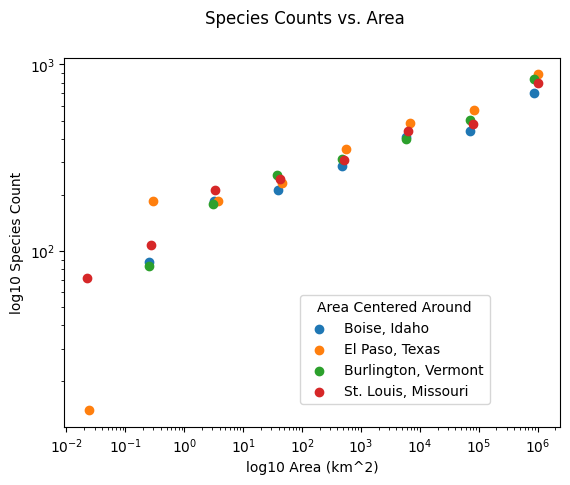

In [22]:
# Plot
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(id_df['area_km'], id_df['species_count'], label="Boise, Idaho")
ax.scatter(tx_df['area_km'], tx_df['species_count'], label="El Paso, Texas")
ax.scatter(vt_df['area_km'], vt_df['species_count'], label="Burlington, Vermont")
ax.scatter(mo_df['area_km'], mo_df['species_count'], label="St. Louis, Missouri")
ax.set_xlabel("log10 Area (km^2)")
ax.set_ylabel("log10 Species Count")
fig.legend(bbox_to_anchor=(0.8, 0.4), title="Area Centered Around")
fig.suptitle("Species Counts vs. Area")

## Islands

In [23]:
"""Create and apply a water body mask
Mostly taken from
https://github.com/ASFHyP3/hyp3-isce2/blob/6216fc00268246e1f10e9e3f6f5c18923b97cfc7/src/hyp3_isce2/water_mask.py#L48
conda requirements:
mamba install -c conda-forge gdal pyproj shapely geopandas-base
"""
import subprocess
import tempfile
from pathlib import Path

import geopandas as gpd
from osgeo import gdal
from shapely import geometry

In [24]:
def calculate_land_percentage(
    input_bbox: tuple[float, float, float, float],
    shapefile_path: str = "data/hyp3_water_mask_20220912.shp",
) -> float:
    """
    Calculate the percentage of land in a given region.
    Parameters
    ----------
    region_extent : tuple
        The extent of the region as a tuple (minx, miny, maxx, maxy).
    shapefile_path : str
        Path to the full water mask shapefile.
    Returns
    -------
    float
        The percentage of land in the given region.
    """

    with tempfile.TemporaryDirectory() as temp_dir:
        # Subset with ogr2ogr
        temp_file_subset = str(Path(temp_dir) / "mask.shp")
        # TODO: might have to do extra options if our bbox crosses -180 degrees
        # There are options in gdal to do this...
        # If might just be adding this to the `ogr2ogr` command in `_clip_vector`
        # cmd = ['ogr2ogr', '-wrapdateline', '-datelineoffset', '20',
        _clip_vector(shapefile_path, temp_file_subset, input_bbox)

        # Read the shapefile into a GeoDataframe
        gdf = gpd.read_file(temp_file_subset)

    # Create a polygon from the region extent
    region_polygon = geometry.box(*input_bbox)

    # Calculate total area of the region
    total_area = region_polygon.area

    # Clip the GeoDataFrame to the region
    clipped_gdf = gdf.clip(region_polygon)

    # Calculate the sum of areas of all land polygons
    land_area = clipped_gdf.area.sum()

    # Calculate the percentage
    land_percentage = (land_area / total_area) * 100

    return land_percentage



def _clip_vector(
    input_filename: str, output_filename: str, bbox: tuple[float, float, float, float]
):
    """Clip a large shapefile to a (left, bottom, right, top) bounding box."""
    cmd = [
        "ogr2ogr",
        str(output_filename),
        str(input_filename),
        "-clipsrc",
        *list(map(str, bbox)),
    ]
    subprocess.run(cmd, check=True)

def calculate_land_area(
    input_bbox: tuple[float, float, float, float],
    shapefile_path: str = "data/hyp3_water_mask_20220912.shp",
) -> float:
    """
    Calculate the percentage of land in a given region.
    Parameters
    ----------
    region_extent : tuple
        The extent of the region as a tuple (minx, miny, maxx, maxy).
    shapefile_path : str
        Path to the full water mask shapefile.
    Returns
    -------
    float
        The percentage of land in the given region.
    """
    # Create a polygon from the region extent
    region_polygon = geometry.box(*input_bbox)

    # Calculate total area of the region
    # total_area = region_polygon.area
    total_area = geod.geometry_area_perimeter(region_polygon)[0]/(1000*1000)
    print("===========")
    print("calc total area in km2", total_area)
    
    with tempfile.TemporaryDirectory() as temp_dir:
        # Subset with ogr2ogr
        temp_file_subset = str(Path(temp_dir) / "mask.shp")
        # TODO: might have to do extra options if our bbox crosses -180 degrees
        # There are options in gdal to do this...
        # If might just be adding this to the `ogr2ogr` command in `_clip_vector`
        # cmd = ['ogr2ogr', '-wrapdateline', '-datelineoffset', '20',
        _clip_vector(shapefile_path, temp_file_subset, input_bbox)

        # Read the shapefile into a GeoDataframe
        gdf = gpd.read_file(temp_file_subset)

    # Clip the GeoDataFrame to the region
    clipped_gdf = gdf.clip(region_polygon)

    # Calculate the sum of areas of all land polygons
    # land_area = clipped_gdf.area.sum()
    def x(polyg):
        return geod.geometry_area_perimeter(polyg)[0]/(1000*1000) * -1
    
    land_area = clipped_gdf['geometry'].map(x).sum()
    return land_area


def island_area_km(b):
    """ return the area on earth of the given lat/long-defined polygon.
    The projection is defined above in settings.
    geod.geometry_area_perimeter returns a tuple of (area, perimeter)
    where area is in m^2. We convert to km^2.
    """
    sp = box(*b)
    area = geod.geometry_area_perimeter(sp)[0]/(1000*1000)
    return calculate_land_area(b)

def df_with_island_area(df):
    """
    Add area calculations to the dataframe.
    """
    df['coord_tuple'] = list(zip(df['max_long'], df['max_lat'], df['min_long'], df['min_lat']))
    df['island_area_km'] = df['coord_tuple'].map(island_area_km)
    return df


### Alaska Islands

In [25]:
# Run query and convert to dataframe
input_lat = 53.7890849
input_long = -166.7241365
windows = get_lat_long_windows(input_lat, input_long)
big_select = multiwindow_species_count_select(windows)
ak_df = duckdb.sql(big_select).df()
ak_df.sort_values(by="min_lat")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,min_lat,max_lat,min_long,max_long,species_count
0,50.000000,60.000000,-170.000000,-160.00000,245
2,51.264646,54.112682,-168.034116,-165.18608,142
1,53.534635,54.345766,-167.092951,-166.28182,138


In [26]:
ak_df

,min_lat,max_lat,min_long,max_long,species_count
0,50.000000,60.000000,-170.000000,-160.00000,245
1,53.534635,54.345766,-167.092951,-166.28182,138
2,51.264646,54.112682,-168.034116,-165.18608,142


In [27]:


# Add necessary columns
ak_df = df_with_area(ak_df)
ak_df = df_with_island_area(ak_df)
ak_df = df_with_log10(ak_df)
ak_df['log10_island_area_km'] = np.log10(ak_df['island_area_km'])


calc total area in km2 709651.9467441719


Warning 1: Value 20154740.0899999999 of field area of feature 0 not successfully written. Possibly due to too larger number with respect to field width


calc total area in km2 4808.909221301453
calc total area in km2 61017.26300788062


Text(0.5, 0.98, 'Starting in Alaska Islands')

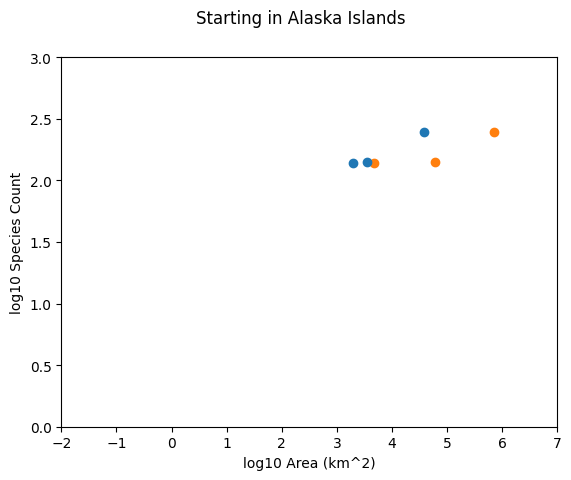

In [28]:
# Plot
fig, ax = plt.subplots()
ax.scatter(ak_df['log10_area_km'], ak_df['log10_species_count'], color='tab:orange')
ax.scatter(ak_df['log10_island_area_km'], ak_df['log10_species_count'], color='tab:blue')
ax.set_xlabel("log10 Area (km^2)")
ax.set_ylabel("log10 Species Count")
ax.set_ylim(0, 3)
ax.set_xlim(-2, 7)
# ax.plot(mo_x, mo_y)
# ax.text(1, 1, f"{slope:.2f}")
fig.suptitle("Starting in Alaska Islands")

### Hawaii

In [29]:
# Run query and convert to dataframe
input_lat = 21.1751609
input_long = -157.0094246
windows = get_lat_long_windows(input_lat, input_long)
big_select = multiwindow_species_count_select(windows)
hi_df = duckdb.sql(big_select).df()
hi_df.sort_values(by="min_lat")
hi_df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,min_lat,max_lat,min_long,max_long,species_count
0,21.119657,21.185450,-157.048661,-156.982867,31
1,19.936251,22.784287,-159.490009,-156.641973,219
2,21.022180,21.253193,-157.088820,-156.857807,59
3,21.089402,21.900532,-157.359381,-156.548250,60
4,20.000000,30.000000,-160.000000,-150.000000,261


In [30]:
# Add necessary columns
hi_df = df_with_area(hi_df)
hi_df = df_with_island_area(hi_df)
hi_df = df_with_log10(hi_df)
hi_df['log10_island_area_km'] = np.log10(hi_df['island_area_km'])

calc total area in km2 49.7797299270401
calc total area in km2 93151.89598724426
calc total area in km2 613.7680260044098
calc total area in km2 7548.869096065888
calc total area in km2 1118167.2993485336


Text(0.5, 0.98, 'Starting in Hawaiian Islands')

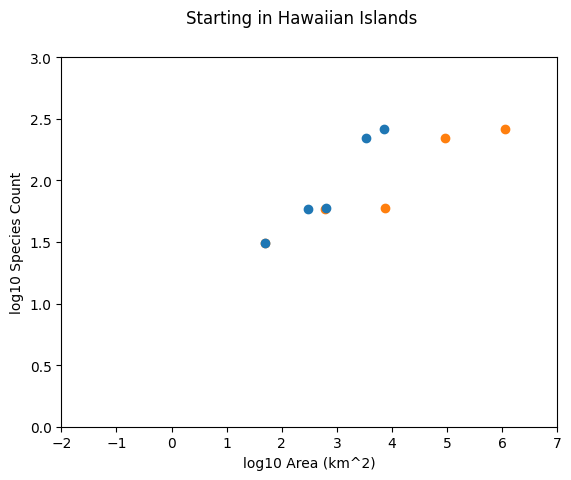

In [31]:
# Plot
fig, ax = plt.subplots()
ax.scatter(hi_df['log10_area_km'], hi_df['log10_species_count'], color='tab:orange')
ax.scatter(hi_df['log10_island_area_km'], hi_df['log10_species_count'], color='tab:blue')
ax.set_xlabel("log10 Area (km^2)")
ax.set_ylabel("log10 Species Count")
ax.set_ylim(0, 3)
ax.set_xlim(-2, 7)
# ax.plot(mo_x, mo_y)
# ax.text(1, 1, f"{slope:.2f}")
fig.suptitle("Starting in Hawaiian Islands")

### Florida Keys

In [32]:
# Run query and convert to dataframe
input_lat = 24.67062
input_long = -81.5425833
windows = get_lat_long_windows(input_lat, input_long)
big_select = multiwindow_species_count_select(windows)
fl_df = duckdb.sql(big_select).df()
fl_df.sort_values(by="min_lat")

# Add necessary columns
fl_df = df_with_area(fl_df)
fl_df = df_with_island_area(fl_df)
fl_df = df_with_log10(fl_df)
fl_df['log10_island_area_km'] = np.log10(fl_df['island_area_km'])
fl_df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

calc total area in km2 7372.5377958684085


Warning 1: Value 20154740.0899999999 of field area of feature 0 not successfully written. Possibly due to too larger number with respect to field width


calc total area in km2 48.54442162051773
calc total area in km2 598.6502091228333
calc total area in km2 3.9366869350881575
calc total area in km2 1118167.2993485336


Warning 1: Value 20154740.0899999999 of field area of feature 0 not successfully written. Possibly due to too larger number with respect to field width


calc total area in km2 91268.0175829895


Warning 1: Value 20154740.0899999999 of field area of feature 0 not successfully written. Possibly due to too larger number with respect to field width


,min_lat,max_lat,min_long,max_long,species_count,shapely_box,area_km,coord_tuple,island_area_km,log10_area_km,log10_species_count,log10_island_area_km
0,24.333925,25.145056,-81.924214,-81.113083,319,POLYGON ((-81.92421390975841 25.14505575448030...,7.372538e+03,"(-81.11308307896873, 25.145055754480303, -81.9...",248.330775,3.867617,2.503791,2.395031
1,24.606703,24.672496,-81.583720,-81.517927,153,POLYGON ((-81.58371985753845 24.67249592465880...,4.854442e+01,"(-81.5179265350727, 24.672495924658808, -81.58...",24.645521,1.686139,2.184691,1.391738
2,24.487375,24.718388,-81.547578,-81.316565,264,POLYGON ((-81.54757841293556 24.71838779088981...,5.986502e+02,"(-81.31656544292724, 24.718387790889818, -81.5...",98.623337,2.777173,2.421604,1.993980
3,24.659437,24.678175,-81.548534,-81.529796,74,POLYGON ((-81.54853424288396 24.67817545907127...,3.936687e+00,"(-81.52979606865536, 24.678175459071273, -81.5...",3.047248,0.595131,1.869232,0.483908
4,20.000000,30.000000,-90.000000,-80.000000,757,"POLYGON ((-90 30, -90 20, -80 20, -80 30, -90 ...",1.118167e+06,"(-80.0, 30.0, -90.0, 20.0)",195357.370866,6.048507,2.879096,5.290830
5,22.784287,25.632323,-82.593040,-79.745004,491,POLYGON ((-82.59304018463826 25.63232281592221...,9.126802e+04,"(-79.74500431620245, 25.632322815922215, -82.5...",13813.835143,4.960319,2.691081,4.140314


Text(0.5, 0.98, 'Starting in Florida Keys')

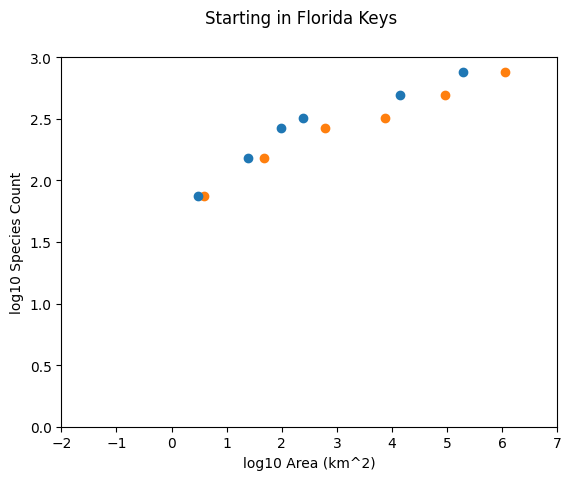

In [33]:
# Plot
fig, ax = plt.subplots()
ax.scatter(fl_df['log10_area_km'], fl_df['log10_species_count'], color='tab:orange')
ax.scatter(fl_df['log10_island_area_km'], fl_df['log10_species_count'], color='tab:blue')
ax.set_xlabel("log10 Area (km^2)")
ax.set_ylabel("log10 Species Count")
ax.set_ylim(0, 3)
ax.set_xlim(-2, 7)
# ax.plot(mo_x, mo_y)
# ax.text(1, 1, f"{slope:.2f}")
fig.suptitle("Starting in Florida Keys")

### Louisiana Delta

In [34]:
# Run query and convert to dataframe
input_lat = 29.1937866
input_long = -90.0813856
windows = get_lat_long_windows(input_lat, input_long)
big_select = multiwindow_species_count_select(windows)
la_df = duckdb.sql(big_select).df()
la_df.sort_values(by="min_lat")

# Add necessary columns
la_df = df_with_area(la_df)
la_df = df_with_island_area(la_df)
la_df = df_with_log10(la_df)
la_df['log10_island_area_km'] = np.log10(la_df['island_area_km'])
la_df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

calc total area in km2 1118167.2993485336


Warning 1: Value 20154740.0899999999 of field area of feature 0 not successfully written. Possibly due to too larger number with respect to field width


calc total area in km2 3.785330597517967


Warning 1: Value 20154740.0899999999 of field area of feature 0 not successfully written. Possibly due to too larger number with respect to field width


calc total area in km2 46.669715696178436


Warning 1: Value 20154740.0899999999 of field area of feature 0 not successfully written. Possibly due to too larger number with respect to field width


calc total area in km2 86833.91276821558


Warning 1: Value 20154740.0899999999 of field area of feature 0 not successfully written. Possibly due to too larger number with respect to field width


calc total area in km2 7119.217141901917


Warning 1: Value 20154740.0899999999 of field area of feature 0 not successfully written. Possibly due to too larger number with respect to field width


calc total area in km2 575.1251483865967


Warning 1: Value 20154740.0899999999 of field area of feature 0 not successfully written. Possibly due to too larger number with respect to field width


,min_lat,max_lat,min_long,max_long,species_count,shapely_box,area_km,coord_tuple,island_area_km,log10_area_km,log10_species_count,log10_island_area_km
0,20.000000,30.000000,-100.000000,-90.000000,809,"POLYGON ((-100 30, -100 20, -90 20, -90 30, -1...",1.118167e+06,"(-90.0, 30.0, -100.0, 20.0)",349536.825444,6.048507,2.907949,5.543493
1,29.175337,29.194075,-90.093142,-90.074404,40,"POLYGON ((-90.09314169112731 29.1940754481648,...",3.785331e+00,"(-90.07440351689873, 29.1940754481648, -90.093...",3.785331,0.578104,1.602060,0.578104
2,29.146442,29.212235,-90.136852,-90.071058,166,POLYGON ((-90.13685177808684 29.21223517479602...,4.666972e+01,"(-90.07105845562108, 29.212235174796028, -90.1...",40.611586,1.669035,2.220108,1.608650
3,28.480359,31.328395,-91.137148,-88.289112,516,POLYGON ((-91.13714778994566 31.32839455279382...,8.683391e+04,"(-88.28911192150986, 31.32839455279382, -91.13...",47814.059233,4.938689,2.712650,4.679556
4,28.389579,29.200710,-90.846653,-90.035522,229,POLYGON ((-90.84665304844498 29.20070990842874...,7.119217e+03,"(-90.03552221765528, 29.200709908428745, -90.8...",425.178665,3.852432,2.359835,2.628571
5,29.107634,29.338647,-90.095058,-89.864045,303,POLYGON ((-90.09505830324323 29.33864719105613...,5.751251e+02,"(-89.86404533323494, 29.338647191056136, -90.0...",93.399555,2.759762,2.481443,1.970345


Text(0.5, 0.98, 'Starting in Louisiana Delta')

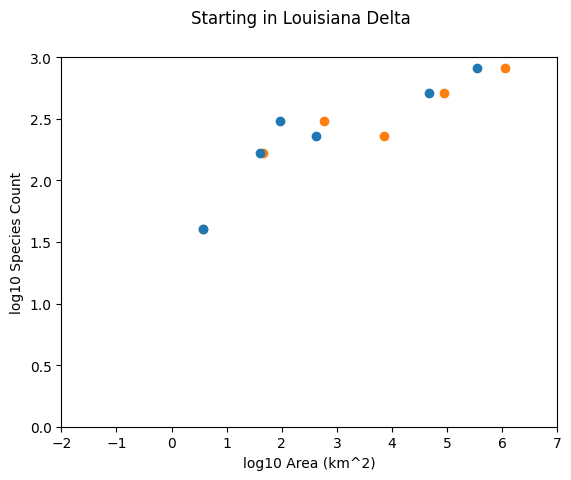

In [35]:
# Plot
fig, ax = plt.subplots()
ax.scatter(la_df['log10_area_km'], la_df['log10_species_count'], color='tab:orange')
ax.scatter(la_df['log10_island_area_km'], la_df['log10_species_count'], color='tab:blue')
ax.set_xlabel("log10 Area (km^2)")
ax.set_ylabel("log10 Species Count")
ax.set_ylim(0, 3)
ax.set_xlim(-2, 7)
# ax.plot(mo_x, mo_y)
# ax.text(1, 1, f"{slope:.2f}")
fig.suptitle("Starting in Louisiana Delta")

### All Islands Grouped

In [36]:
new_island_df = pd.concat([ak_df, hi_df, fl_df, la_df])
total_x, total_y, slope = best_fit_line(new_island_df)

                  Results: Ordinary least squares
Model:              OLS                 Adj. R-squared:     0.485   
Dependent Variable: log10_species_count AIC:                8.8897  
Date:               2023-12-13 11:31    BIC:                10.8812 
No. Observations:   20                  Log-Likelihood:     -2.4449 
Df Model:           1                   F-statistic:        18.91   
Df Residuals:       18                  Prob (F-statistic): 0.000387
R-squared:          0.512               Scale:              0.083073
----------------------------------------------------------------------
                Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
----------------------------------------------------------------------
const           1.6774     0.1498   11.1961   0.0000   1.3626   1.9922
log10_area_km   0.1601     0.0368    4.3490   0.0004   0.0828   0.2374
--------------------------------------------------------------------
Omnibus:                4.140         Durbi

Text(0.5, 0.98, 'Islands: Species Count vs. Area')

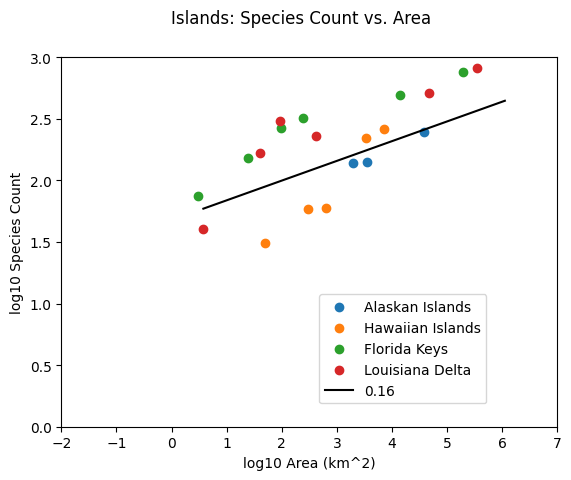

In [41]:
# Plot
fig, ax = plt.subplots()
ax.scatter(ak_df['log10_island_area_km'], ak_df['log10_species_count'], label="Alaskan Islands")
ax.scatter(hi_df['log10_island_area_km'], hi_df['log10_species_count'], label="Hawaiian Islands")
ax.scatter(fl_df['log10_island_area_km'], fl_df['log10_species_count'], label="Florida Keys")
ax.scatter(la_df['log10_island_area_km'], la_df['log10_species_count'], label="Louisiana Delta")
ax.set_xlabel("log10 Area (km^2)")
ax.set_ylabel("log10 Species Count")
ax.set_ylim(0, 3)
ax.set_xlim(-2, 7)
ax.plot(total_x, total_y, color='black', label=f"{slope:.2f}")
# fig.legend(loc='center right')
fig.legend(bbox_to_anchor=(0.8, 0.4))
fig.suptitle("Islands: Species Count vs. Area")